# 实验三：基于 DeepLabv3 的语义分割 (PyTorch基础版)

本 Notebook 实现了使用 PyTorch 和预训练的 DeepLabv3 模型对 PASCAL VOC2012 数据集进行语义分割。

**实验流程:**
1.  **环境设置**: 导入所需库并设置计算设备。
2.  **数据准备**: 创建一个自定义的 `Dataset` 类来加载和预处理 VOC2012 数据。
3.  **模型构建**: 加载 `torchvision` 中预训练的 DeepLabv3 模型，并根据我们的任务修改其分类头。
4.  **模型微调**: 在 VOC2012 训练集上对模型的分类头进行微调。
5.  **结果验证与可视化**: 加载训练好的模型，在验证集上进行预测，并将分割结果可视化。

**文件结构要求:**
- 数据集应解压在 `./data/VOC2012/` 目录下。
- 最终训练好的模型将保存为 `./deeplabv3_voc.pth`。

In [1]:
# ==============================================================================
# 1. 导入所需的库
# 包含了 PyTorch、torchvision、图像处理和可视化的常用库
# ==============================================================================
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchvision.transforms.functional as F
import random
import warnings
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

warnings.filterwarnings("ignore")
# 检查并打印 PyTorch 版本
print(f"PyTorch Version: {torch.__version__}")

# 设置计算设备 (优先使用 GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

PyTorch Version: 2.5.1+cu121
Using device: cuda


In [2]:
# ==============================================================================
# 2. 定义超参数和文件路径
# ==============================================================================
# 数据集有20个类别 + 1个背景类别
NUM_CLASSES = 21 
# 数据集根目录
DATA_DIR = 'data/VOC2012'
# 模型保存路径
MODEL_SAVE_PATH = 'deeplabv3_voc.pth'

# 训练参数
# --- MODIFIED ---
# BATCH_SIZE 减小以降低显存使用。如果仍然内存不足，可以尝试 2。
BATCH_SIZE = 4 
EPOCHS = 5     # 训练轮次
LEARNING_RATE = 0.01

In [3]:
# ==============================================================================
# 3. 创建自定义数据集类
# 这个类用于加载 PASCAL VOC2012 数据集。
# 它会读取图片和对应的分割掩码，并进行必要的预处理和数据增强。
# ==============================================================================
class VOCDataset(Dataset):
    """
    PASCAL VOC2012 语义分割数据集的自定义数据集类。
    """
    def __init__(self, root, split='train', crop_size=(513, 513), ignore_label=255):
        self.root = root
        self.split = split
        self.crop_size = crop_size
        self.ignore_label = ignore_label
        
        self.images_dir = os.path.join(root, 'JPEGImages')
        self.masks_dir = os.path.join(root, 'SegmentationClass')
        
        list_file = os.path.join(root, f'ImageSets/Segmentation/{split}.txt')
        with open(list_file, 'r') as f:
            self.filenames = [line.strip() for line in f.readlines()]

        # PDF中使用的图像均值和标准差 (从BGR转换为RGB顺序)
        self.mean = [123.675, 116.28, 103.53]
        self.std = [58.395, 57.120, 57.375]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        
        img_path = os.path.join(self.images_dir, f'{filename}.jpg')
        mask_path = os.path.join(self.masks_dir, f'{filename}.png')
        
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path)
        
        # --- 数据增强和预处理 ---
        # 1. 随机缩放 (0.5 - 2.0)
        scale_factor = random.uniform(0.5, 2.0)
        new_size = (int(image.size[0] * scale_factor), int(image.size[1] * scale_factor))
        image = image.resize(new_size, Image.BILINEAR)
        mask = mask.resize(new_size, Image.NEAREST)

        # 2. 随机裁剪到 crop_size
        if image.size[0] < self.crop_size[0] or image.size[1] < self.crop_size[1]:
            pad_w = max(0, self.crop_size[0] - image.size[0])
            pad_h = max(0, self.crop_size[1] - image.size[1])
            image = F.pad(image, (0, 0, pad_w, pad_h), fill=0)
            mask = F.pad(mask, (0, 0, pad_w, pad_h), fill=self.ignore_label)

        x = random.randint(0, image.size[0] - self.crop_size[0])
        y = random.randint(0, image.size[1] - self.crop_size[1])
        image = image.crop((x, y, x + self.crop_size[0], y + self.crop_size[1]))
        mask = mask.crop((x, y, x + self.crop_size[0], y + self.crop_size[1]))

        # 3. 随机水平翻转
        if random.random() > 0.5:
            image = F.hflip(image)
            mask = F.hflip(mask)
        
        # 4. 转换为 Tensor 并进行归一化
        image = F.to_tensor(image) * 255.0
        image = F.normalize(image, mean=self.mean, std=self.std)
        
        mask = torch.from_numpy(np.array(mask)).long()

        return image, mask

In [4]:
# ==============================================================================
# 4. 定义模型、损失函数和优化器
# ==============================================================================
def create_model(num_classes):
    """
    创建 DeepLabv3 模型。
    - 使用在 COCO 上预训练的 ResNet-101 作为骨干网络。
    - 替换分类头以匹配我们的类别数。
    - 冻结骨干网络，只微调分类头。
    """
    model = models.segmentation.deeplabv3_resnet101(pretrained=True, progress=True)
    model.classifier = DeepLabHead(2048, num_classes)
    
    # 冻结骨干网络参数
    for param in model.backbone.parameters():
        param.requires_grad = False
    return model

# 实例化模型、损失函数、优化器和学习率调度器
model = create_model(NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=0)

# 创建 DataLoader
train_dataset = VOCDataset(root=DATA_DIR, split='train')
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)

In [5]:
# ==============================================================================
# 5. 训练模型
# ==============================================================================
print("开始微调训练...")
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    
    for images, masks in progress_bar:
        images = images.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)['out']
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    epoch_loss = running_loss / len(train_loader)
    scheduler.step()
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {epoch_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")

# 保存模型权重
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"训练完成，模型已保存至 {MODEL_SAVE_PATH}")

开始微调训练...


Epoch 1/5: 100%|██████████| 366/366 [00:57<00:00,  6.36it/s, loss=0.3412]


Epoch [1/5], Loss: 0.6539, LR: 0.009045


Epoch 2/5: 100%|██████████| 366/366 [00:58<00:00,  6.28it/s, loss=0.5704]


Epoch [2/5], Loss: 0.4102, LR: 0.006545


Epoch 3/5: 100%|██████████| 366/366 [00:59<00:00,  6.17it/s, loss=0.0965]


Epoch [3/5], Loss: 0.3115, LR: 0.003455


Epoch 4/5: 100%|██████████| 366/366 [00:59<00:00,  6.16it/s, loss=0.1751]


Epoch [4/5], Loss: 0.2802, LR: 0.000955


Epoch 5/5: 100%|██████████| 366/366 [00:59<00:00,  6.16it/s, loss=0.1080]


Epoch [5/5], Loss: 0.2501, LR: 0.000000
训练完成，模型已保存至 deeplabv3_voc.pth


In [9]:
# ==============================================================================
# 6. 验证和可视化
# ==============================================================================
# 为PASCAL VOC数据集的21个类别定义颜色映射
VOC_COLORMAP = np.array([
    [0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128],
    [128, 0, 128], [0, 128, 128], [128, 128, 128], [64, 0, 0], [192, 0, 0],
    [64, 128, 0], [192, 128, 0], [64, 0, 128], [192, 0, 128],
    [64, 128, 128], [192, 128, 128], [0, 64, 0], [128, 64, 0],
    [0, 192, 0], [128, 192, 0], [0, 64, 128]
], dtype=np.uint8)

def visualize_prediction(model, image_path, mask_path):
    """
    加载一张图片和它的真实掩码，用训练好的模型进行预测，
    并并排显示 原图 | 预测结果 | 真实标签。
    """
    image = Image.open(image_path).convert('RGB')
    
    # 预处理
    input_image = F.to_tensor(image) * 255.0
    input_image = F.normalize(input_image, mean=[123.675, 116.28, 103.53], std=[58.395, 57.120, 57.375])
    input_image = input_image.unsqueeze(0).to(device)

    # 模型预测
    model.eval()
    with torch.no_grad():
        output = model(input_image)['out'][0]
    
    # 处理预测结果
    pred_mask = torch.argmax(output, dim=0).cpu().numpy()
    pred_mask_colored = VOC_COLORMAP[pred_mask]

    # 加载真实掩码
    true_mask_pil = Image.open(mask_path)
    true_mask_np = np.array(true_mask_pil)
    
    # ==================================================================
    #  !!! BUG 修正 !!!
    # 将 "ignore" 标签 (255) 映射到背景 (0) 以便进行可视化，防止 IndexError
    # ==================================================================
    true_mask_np[true_mask_np == 255] = 0
    
    true_mask_colored = VOC_COLORMAP[true_mask_np]

    # 可视化
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1); plt.title("Original Image"); plt.imshow(image); plt.axis('off')
    plt.subplot(1, 3, 2); plt.title("Predicted Mask"); plt.imshow(pred_mask_colored); plt.axis('off')
    plt.subplot(1, 3, 3); plt.title("Ground Truth"); plt.imshow(true_mask_colored); plt.axis('off')
    plt.show()

成功加载已训练的模型权重！

--- 正在处理图片: 2007_003742 ---


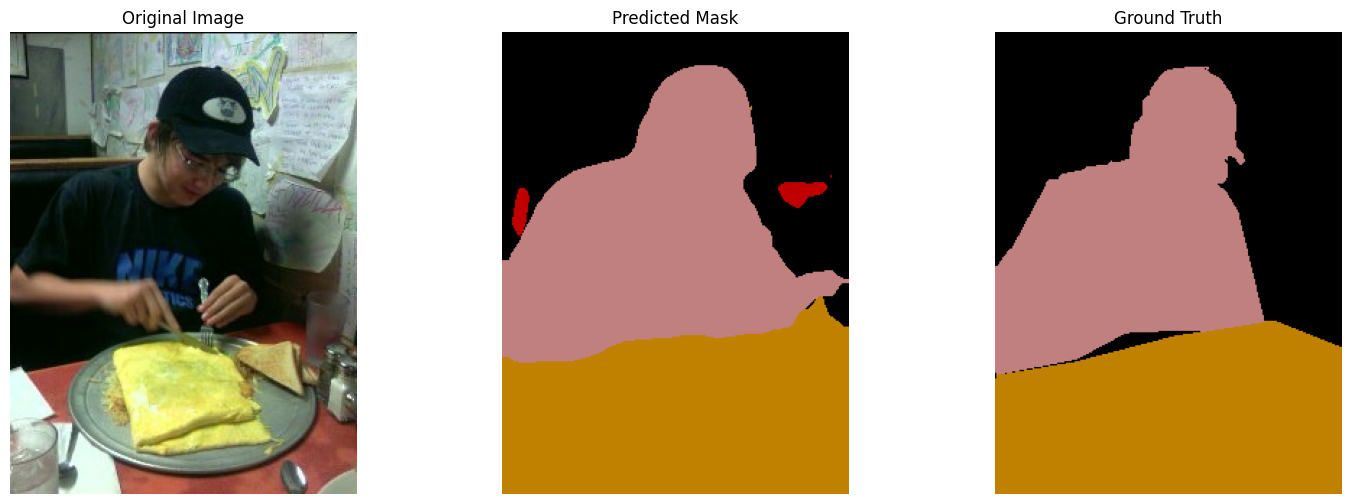


--- 正在处理图片: 2007_001288 ---


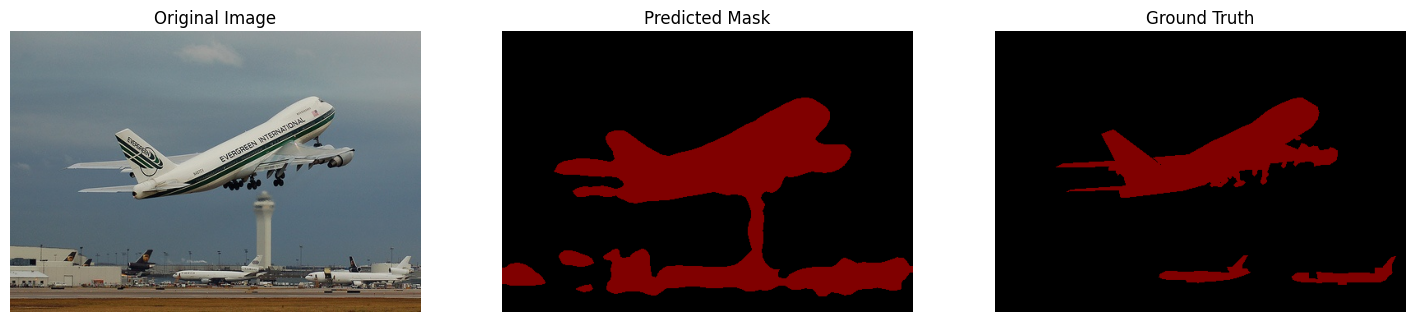


--- 正在处理图片: 2011_002754 ---


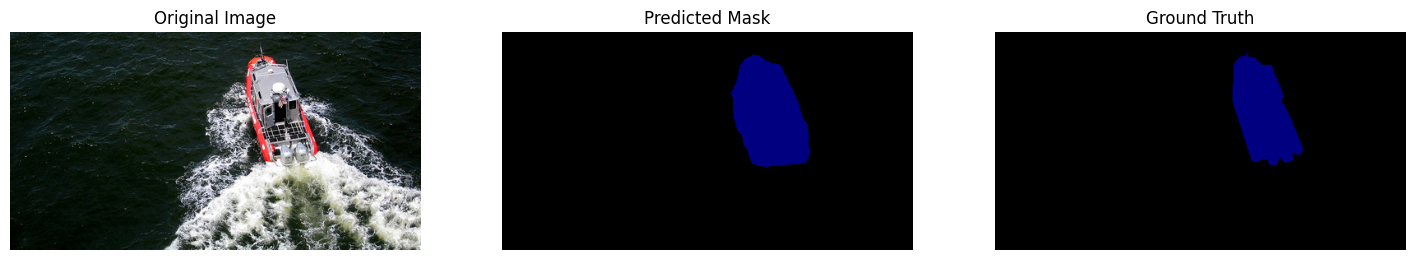


--- 正在处理图片: 2009_001215 ---


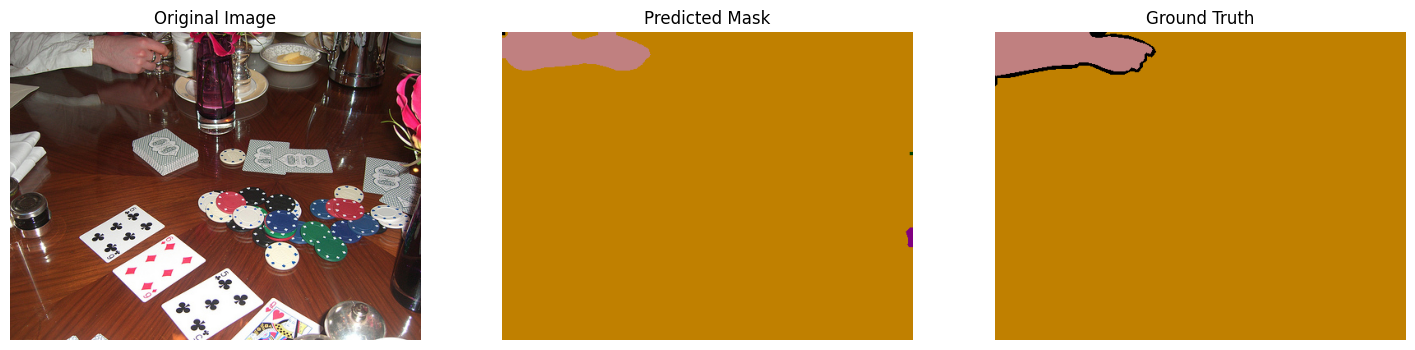


--- 正在处理图片: 2008_006063 ---


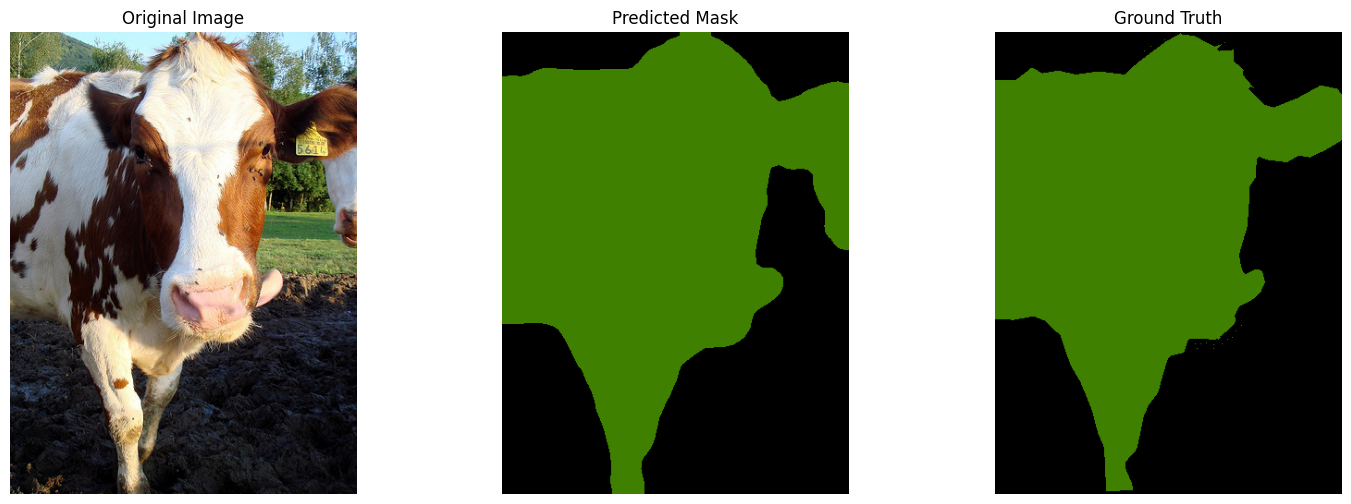


--- 正在处理图片: 2009_000931 ---


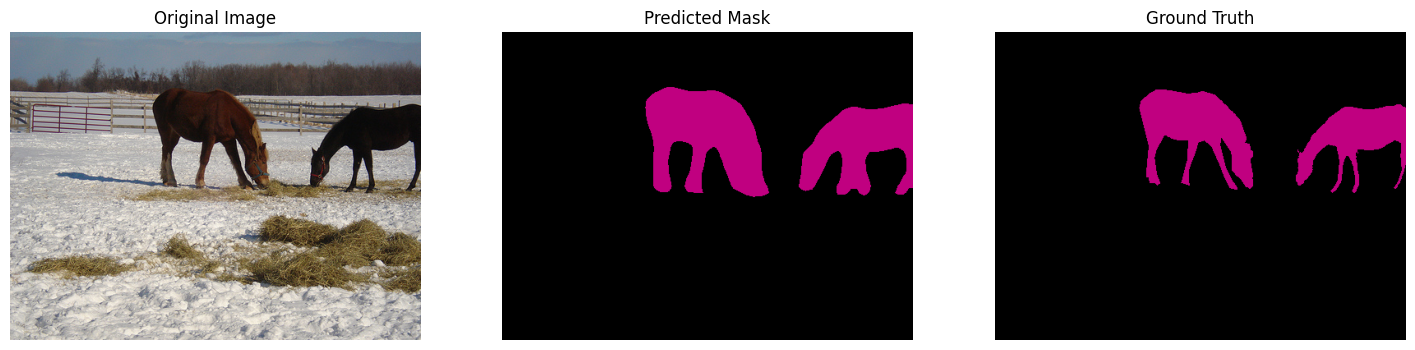

In [11]:
# ==============================================================================
# 7. 加载训练好的模型并进行可视化
# ==============================================================================
# 实例化一个新模型并加载权重
eval_model = create_model(NUM_CLASSES)
try:
    eval_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
    eval_model.to(device)
    print("成功加载已训练的模型权重！")

    # 从验证集中随机选择3张图片进行测试
    val_list_file = os.path.join(DATA_DIR, 'ImageSets/Segmentation/val.txt')
    with open(val_list_file, 'r') as f:
        val_filenames = [line.strip() for line in f.readlines()]
    
    sample_filenames = random.sample(val_filenames, 6)

    for filename in sample_filenames:
        print(f"\n--- 正在处理图片: {filename} ---")
        img_path = os.path.join(DATA_DIR, 'JPEGImages', f'{filename}.jpg')
        mask_path = os.path.join(DATA_DIR, 'SegmentationClass', f'{filename}.png')
        visualize_prediction(eval_model, img_path, mask_path)

except FileNotFoundError:
    print(f"错误: 找不到模型文件 {MODEL_SAVE_PATH}。请先运行训练部分的Cell。")

---
# 模型改进与对比实验

在前面的单元格中，我们成功地微调了一个基础模型。现在，我们将采用更先进的策略来训练一个表现更出色的模型，并将其与原始模型进行**量化**和**可视化**的对比。

**我们的改进策略包括：**
1.  **引入标准评估指标 (mIoU)**: 使用语义分割领域最核心的指标——平均交并比 (Mean Intersection over Union) 来客观评估模型性能。
2.  **增加验证循环**: 在每个训练周期后，使用独立的验证集来评估模型的泛化能力，防止过拟合。
3.  **更优的训练策略**:
    *   使用 `AdamW` 优化器，通常比 `SGD` 收敛更快。
    *   在训练后期**解冻骨干网络**，对整个模型进行微调，以更好地适应数据集。
4.  **保存最佳模型**: 只保存在验证集上 mIoU 表现最好的模型权重。
---

In [12]:
# ==============================================================================
# 改进一：定义核心评估指标 mIoU (Mean Intersection over Union)
# ==============================================================================

def calculate_iou(pred, target, num_classes):
    """计算一个批次数据的 mIoU"""
    pred = pred.view(-1)
    target = target.view(-1)
    # 忽略值为 255 的标签
    valid_mask = (target != 255)
    pred = pred[valid_mask]
    target = target[valid_mask]
    
    iou_per_class = []
    for cls in range(num_classes):
        pred_inds = (pred == cls)
        target_inds = (target == cls)
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        
        if union == 0:
            # 如果某个类别在真值和预测中都未出现，则IoU为NaN，后续计算时会忽略
            iou_per_class.append(float('nan'))
        else:
            iou_per_class.append(intersection / union)
            
    # 计算所有有效类别IoU的平均值
    return np.nanmean(iou_per_class) if iou_per_class else 0.0

print("mIoU 计算函数已定义。")

mIoU 计算函数已定义。


In [13]:
# ==============================================================================
# 改进二：使用更优的策略训练一个新模型
# ==============================================================================

# 为新模型定义一个不同的保存路径
IMPROVED_MODEL_SAVE_PATH = 'deeplabv3_voc_improved.pth'

# 1. 重新实例化一个新模型
improved_model = create_model(NUM_CLASSES).to(device)

# 2. 定义新的优化器和数据加载器
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, improved_model.parameters()), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-5)

val_dataset = VOCDataset(root=DATA_DIR, split='val', crop_size=(513, 513))
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

# 3. 训练与验证循环
print("开始训练进阶版模型...")
best_miou = 0.0
UNFREEZE_EPOCH = 2 # 设置在第几轮后解冻骨干网络

for epoch in range(EPOCHS):
    # --- 训练阶段 ---
    improved_model.train()
    if epoch == UNFREEZE_EPOCH:
        print("\n" + "="*30 + f"\nEpoch {epoch+1}: 解冻骨干网络！\n" + "="*30 + "\n")
        for param in improved_model.backbone.parameters():
            param.requires_grad = True
        # 为所有参数创建一个新的优化器，并使用更小的学习率
        optimizer = optim.AdamW(improved_model.parameters(), lr=LEARNING_RATE / 10, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS-UNFREEZE_EPOCH, eta_min=1e-6)

    train_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]")
    for images, masks in progress_bar:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = improved_model(images)['out']
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")
        
    avg_train_loss = train_loss / len(train_loader)

    # --- 验证阶段 ---
    improved_model.eval()
    val_miou_list = []
    with torch.no_grad():
        progress_bar_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]")
        for images, masks in progress_bar_val:
            images, masks = images.to(device), masks.to(device)
            outputs = improved_model(images)['out']
            preds = torch.argmax(outputs, dim=1)
            miou = calculate_iou(preds, masks, NUM_CLASSES)
            val_miou_list.append(miou)
            progress_bar_val.set_postfix(mIoU=f"{miou:.4f}")

    avg_val_miou = np.mean(val_miou_list)
    scheduler.step()
    print(f"Epoch [{epoch+1}/{EPOCHS}] -> Train Loss: {avg_train_loss:.4f}, Val mIoU: {avg_val_miou:.4f}")

    if avg_val_miou > best_miou:
        best_miou = avg_val_miou
        torch.save(improved_model.state_dict(), IMPROVED_MODEL_SAVE_PATH)
        print(f"*** 发现更佳模型！mIoU: {best_miou:.4f}，已保存至 {IMPROVED_MODEL_SAVE_PATH} ***")

开始训练进阶版模型...


Epoch 1/5 [Val]: 100%|██████████| 363/363 [00:56<00:00,  6.41it/s, mIoU=0.0730]


Epoch [1/5] -> Train Loss: 0.9362, Val mIoU: 0.2989
*** 发现更佳模型！mIoU: 0.2989，已保存至 deeplabv3_voc_improved.pth ***


Epoch 2/5 [Val]: 100%|██████████| 363/363 [00:57<00:00,  6.32it/s, mIoU=0.1898]


Epoch [2/5] -> Train Loss: 0.5488, Val mIoU: 0.4843
*** 发现更佳模型！mIoU: 0.4843，已保存至 deeplabv3_voc_improved.pth ***

Epoch 3: 解冻骨干网络！



Epoch 3/5 [Val]: 100%|██████████| 363/363 [00:58<00:00,  6.23it/s, mIoU=0.0547]


Epoch [3/5] -> Train Loss: 1.5507, Val mIoU: 0.1197


Epoch 4/5 [Val]: 100%|██████████| 363/363 [00:58<00:00,  6.24it/s, mIoU=0.0360]


Epoch [4/5] -> Train Loss: 1.3631, Val mIoU: 0.0480


Epoch 5/5 [Val]: 100%|██████████| 363/363 [00:57<00:00,  6.27it/s, mIoU=0.1480]

Epoch [5/5] -> Train Loss: 1.3318, Val mIoU: 0.0844


In [14]:
# ==============================================================================
# 对比一：mIoU 分数比较
# ==============================================================================

def evaluate_model_miou(model, data_loader, device):
    """在给定的数据集上评估模型的 mIoU"""
    model.eval()
    all_miou = []
    with torch.no_grad():
        for images, masks in tqdm(data_loader, desc="Evaluating"):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)['out']
            preds = torch.argmax(outputs, dim=1)
            miou = calculate_iou(preds, masks, NUM_CLASSES)
            all_miou.append(miou)
    return np.mean(all_miou)

# 加载原始模型
original_model = create_model(NUM_CLASSES).to(device)
original_model.load_state_dict(torch.load(MODEL_SAVE_PATH))

# 加载改进后的模型
improved_model_eval = create_model(NUM_CLASSES).to(device)
improved_model_eval.load_state_dict(torch.load(IMPROVED_MODEL_SAVE_PATH))

print("正在验证集上评估两个模型...")
original_miou = evaluate_model_miou(original_model, val_loader, device)
improved_miou = evaluate_model_miou(improved_model_eval, val_loader, device)

print("\n" + "="*40)
print("       模型性能量化对比 (mIoU)")
print("="*40)
print(f"原始模型 mIoU: {original_miou:.4f}")
print(f"改进模型 mIoU: {improved_miou:.4f}")
print("="*40)

if improved_miou > original_miou:
    print("\n结论：改进后的模型在 mIoU 指标上表现更出色！")
else:
    print("\n结论：改进策略未带来明显提升，可以尝试调整超参数或增加训练轮次。")

正在验证集上评估两个模型...


Evaluating: 100%|██████████| 363/363 [00:57<00:00,  6.30it/s]


       模型性能量化对比 (mIoU)
原始模型 mIoU: 0.6023
改进模型 mIoU: 0.4940

结论：改进策略未带来明显提升，可以尝试调整超参数或增加训练轮次。


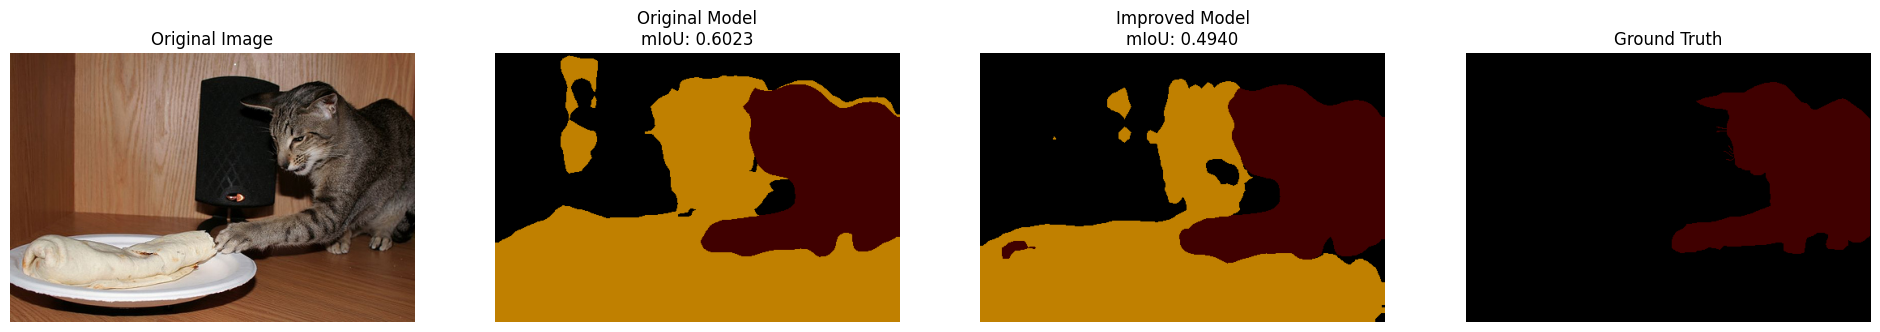

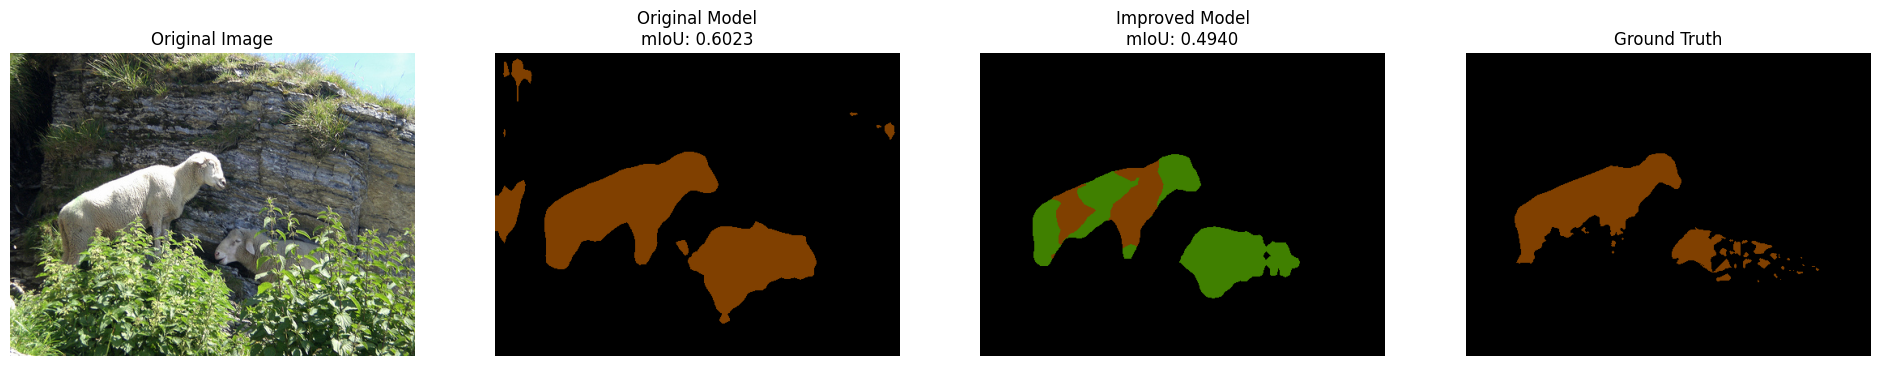

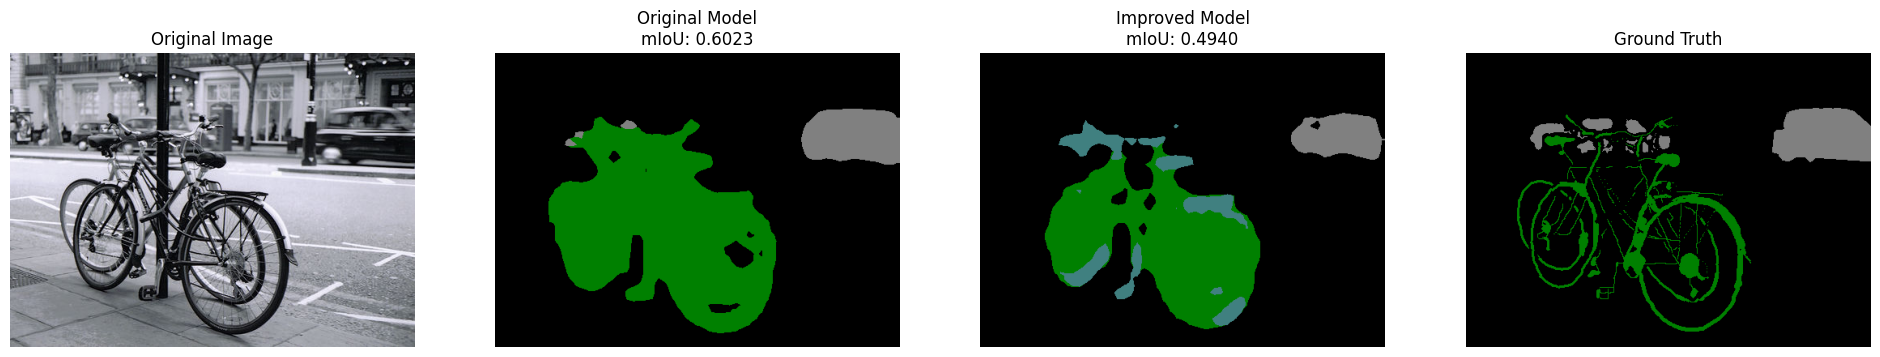

In [15]:
# ==============================================================================
# 对比二：分割效果可视化比较
# ==============================================================================

def visualize_comparison(model1, model2, image_path, mask_path):
    """并排显示原图、两个模型的预测以及真实标签"""
    image = Image.open(image_path).convert('RGB')
    
    # --- 预处理 ---
    input_image = F.to_tensor(image) * 255.0
    input_image = F.normalize(input_image, mean=[123.675, 116.28, 103.53], std=[58.395, 57.120, 57.375])
    input_image = input_image.unsqueeze(0).to(device)

    # --- 模型预测 ---
    model1.eval()
    model2.eval()
    with torch.no_grad():
        pred1 = torch.argmax(model1(input_image)['out'][0], dim=0).cpu().numpy()
        pred2 = torch.argmax(model2(input_image)['out'][0], dim=0).cpu().numpy()
        
    mask1_colored = VOC_COLORMAP[pred1]
    mask2_colored = VOC_COLORMAP[pred2]

    # --- 加载真实标签 ---
    true_mask_pil = Image.open(mask_path)
    true_mask_np = np.array(true_mask_pil)
    true_mask_np[true_mask_np == 255] = 0
    true_mask_colored = VOC_COLORMAP[true_mask_np]

    # --- 可视化 ---
    plt.figure(figsize=(24, 6))
    plt.subplot(1, 4, 1); plt.title("Original Image"); plt.imshow(image); plt.axis('off')
    plt.subplot(1, 4, 2); plt.title(f"Original Model\nmIoU: {original_miou:.4f}"); plt.imshow(mask1_colored); plt.axis('off')
    plt.subplot(1, 4, 3); plt.title(f"Improved Model\nmIoU: {improved_miou:.4f}"); plt.imshow(mask2_colored); plt.axis('off')
    plt.subplot(1, 4, 4); plt.title("Ground Truth"); plt.imshow(true_mask_colored); plt.axis('off')
    plt.show()

# 从验证集中随机选择3张图片进行对比
val_list_file = os.path.join(DATA_DIR, 'ImageSets/Segmentation/val.txt')
with open(val_list_file, 'r') as f:
    val_filenames = [line.strip() for line in f.readlines()]
sample_filenames = random.sample(val_filenames, 3)

for filename in sample_filenames:
    img_path = os.path.join(DATA_DIR, 'JPEGImages', f'{filename}.jpg')
    mask_path = os.path.join(DATA_DIR, 'SegmentationClass', f'{filename}.png')
    visualize_comparison(original_model, improved_model_eval, img_path, mask_path)